In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3

import milopy.core as milo
import milopy.plot as milopl

In [3]:
input_file = "./CTCL/objects/stromal_allgenes.h5ad"
adata = sc.read_h5ad(input_file)

In [4]:
adata

AnnData object with n_obs × n_vars = 391693 × 15777
    obs: 'Sanger_ID', 'tissue', 'site', 'Sex', 'batch', 'n_counts', 'n_genes', 'percent_mito', 'study', 'donor', 'tech', 'sample_type'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'neighbors', 'sample_type_colors'
    obsm: 'X_scVI', 'X_scVI_MDE', '_scvi_extra_categorical_covs'
    layers: 'raw_counts'
    obsp: 'connectivities', 'distances'

In [5]:
adata.X.expm1().sum(axis = 1)

/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/scipy/sparse/data.py:133: RuntimeWarning: overflow encountered in expm1
  result = op(self._deduped_data())


matrix([[7.55158742e+185],
        [1.54605744e+025],
        [9.01999649e+006],
        ...,
        [6.56728315e+007],
        [2.42058720e+007],
        [1.80065703e+015]])

In [39]:
adata.obs['sample_type'].value_counts()

healthy_skin    114496
ctcl            107432
psoriasis        94832
AD               74933
Name: sample_type, dtype: int64

In [41]:
adata.obs['Condition'] = "a_Other"
ll = adata.obs['sample_type'] == 'ctcl'
adata.obs.loc[ll, 'Condition'] = 'CTCL'

In [42]:
adata.obs['Condition'].value_counts()

a_Other    284261
CTCL       107432
Name: Condition, dtype: int64

In [43]:
## Recompute KNN graph
sc.pp.neighbors(adata, use_rep = "X_scVI", n_neighbors = 100, key_added="scvi")

## Construct neighbourhoods
milo.make_nhoods(adata, neighbors_key="scvi", prop=0.05)

computing neighbors


/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/numba/core/typed_passes.py:327: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../my-conda-envs/myenv_old/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../my-c

    finished: added to `.uns['scvi']`
    `.obsp['scvi_distances']`, distances for each pair of neighbors
    `.obsp['scvi_connectivities']`, weighted adjacency matrix (0:04:50)


In [44]:
adata[adata.obs['nhood_ixs_refined'] != 0].obs[['nhood_ixs_refined', 'nhood_kth_distance']]

,nhood_ixs_refined,nhood_kth_distance
AAACCTGCACGAGAGT-0_CTCL1_CTCL1_CTCL1,1,1.488195
AAACGGGGTCATCCCT-0_CTCL1_CTCL1_CTCL1,1,1.308960
AAAGATGCATTGCGGC-0_CTCL1_CTCL1_CTCL1,1,1.067566
AAAGCAACATGCATGT-0_CTCL1_CTCL1_CTCL1,1,0.948112
AAAGTAGAGGCCCGTT-0_CTCL1_CTCL1_CTCL1,1,1.063251
...,...,...
TATCTCACATCGGACC-92_S5,1,0.875444
GTGTTAGCAGCCAGAA-92_S5,1,0.852262
TTTATGCGTAAACCTC-92_S5,1,0.818984
AGCGTATTCCGCAGTG-92_S5,1,0.800838


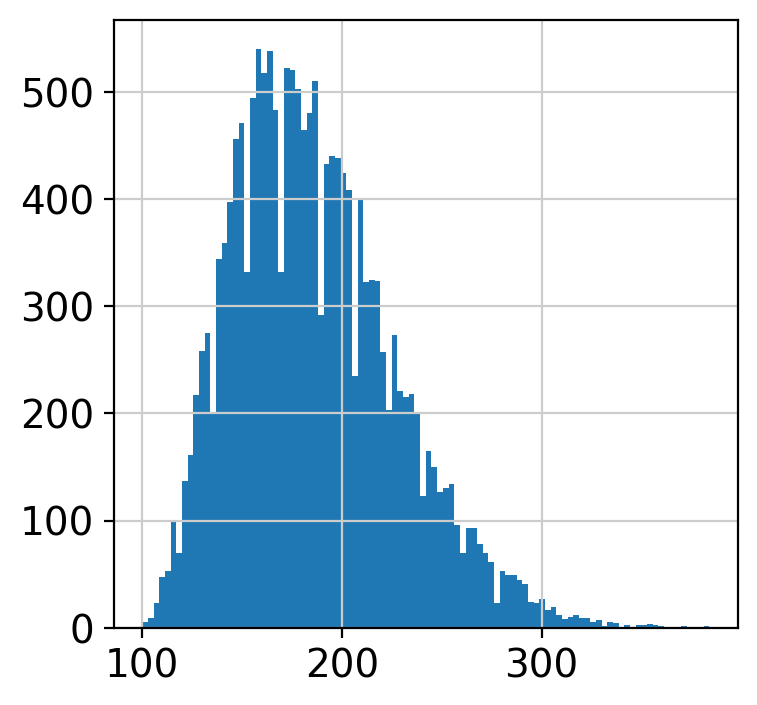

In [45]:
nhood_size = np.array(adata.obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=100);

In [46]:
milo.count_nhoods(adata, sample_col="donor")

/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/milopy/core.py:157: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  nhood_adata = anndata.AnnData(X=nhood_count_mat, var=nhood_var)


In [47]:
milo.DA_nhoods(adata, design="~Condition")

/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:2085: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  values, tz_parsed = conversion.datetime_to_datetime64(data)


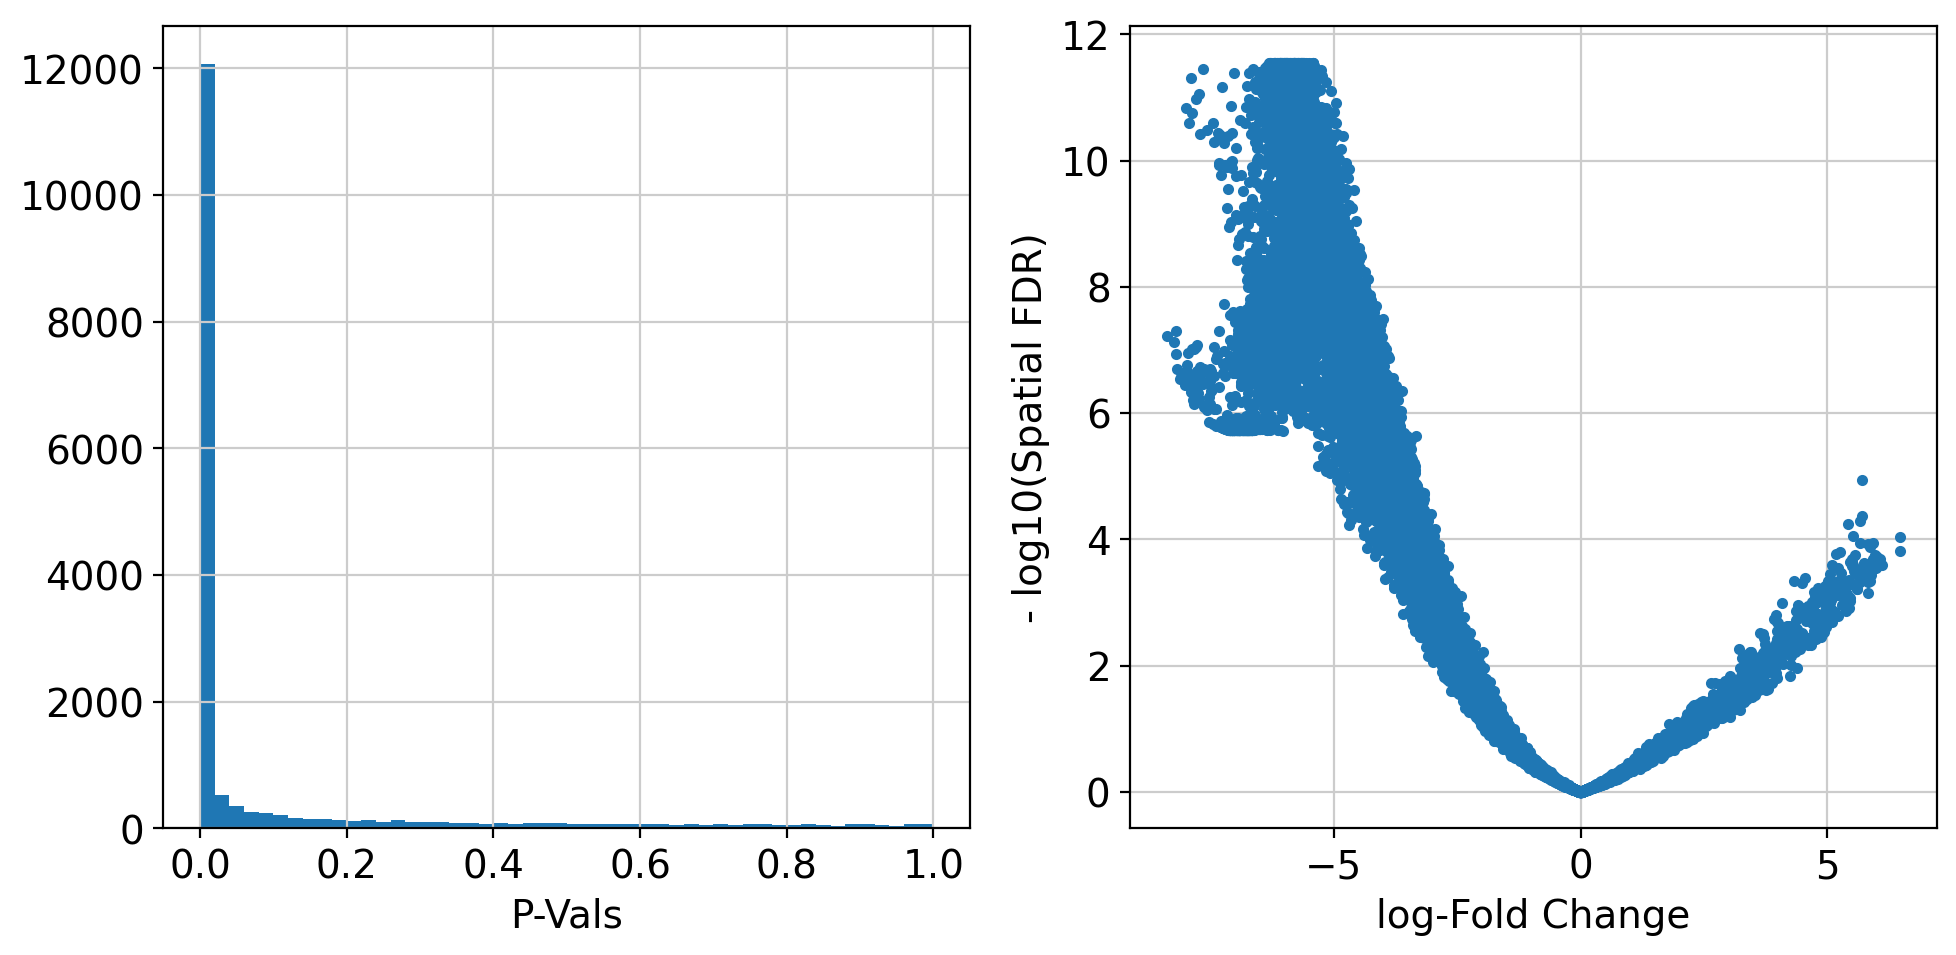

In [48]:
old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [10,5]
plt.subplot(1,2,1)
plt.hist(adata.uns["nhood_adata"].obs.PValue, bins=50);
plt.xlabel("P-Vals");
plt.subplot(1,2,2)
plt.plot(adata.uns["nhood_adata"].obs.logFC, -np.log10(adata.uns["nhood_adata"].obs.SpatialFDR), '.');
plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)");
plt.tight_layout()
plt.rcParams["figure.figsize"] = old_figsize

In [49]:
milo_results = adata.uns["nhood_adata"].obs
milo_results

,index_cell,kth_distance,logFC,logCPM,F,PValue,FDR,SpatialFDR
0,AAACCTGCACGAGAGT-0_CTCL1_CTCL1_CTCL1,1.488195,-0.385463,8.400956,0.166858,6.842089e-01,7.244196e-01,7.216805e-01
1,AAACGGGGTCATCCCT-0_CTCL1_CTCL1_CTCL1,1.308960,0.190657,8.485743,0.036571,8.489135e-01,8.709475e-01,8.694060e-01
2,AAAGATGCATTGCGGC-0_CTCL1_CTCL1_CTCL1,1.067566,0.663665,8.537818,0.408101,5.250913e-01,5.750826e-01,5.714359e-01
3,AAAGCAACATGCATGT-0_CTCL1_CTCL1_CTCL1,0.948112,-2.055721,8.281745,6.894667,1.068092e-02,1.586876e-02,1.536397e-02
4,AAAGTAGAGGCCCGTT-0_CTCL1_CTCL1_CTCL1,1.063251,0.336597,8.577043,0.099972,7.528370e-01,7.863570e-01,7.840689e-01
...,...,...,...,...,...,...,...,...
17308,TATCTCACATCGGACC-92_S5,0.875444,-6.033974,8.306699,59.817428,7.038250e-09,3.889347e-08,3.821560e-08
17309,GTGTTAGCAGCCAGAA-92_S5,0.852262,-4.925665,8.475049,44.470337,5.186224e-09,3.054587e-08,3.003876e-08
17310,TTTATGCGTAAACCTC-92_S5,0.818984,-3.989275,8.668809,23.357037,7.843792e-06,1.721815e-05,1.598716e-05
17311,AGCGTATTCCGCAGTG-92_S5,0.800838,-4.015401,8.605688,26.770098,2.126079e-06,5.015506e-06,4.616560e-06


In [50]:
import milopy.utils
milopy.utils.build_nhood_graph(adata, basis = 'X_scVI_MDE')

/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


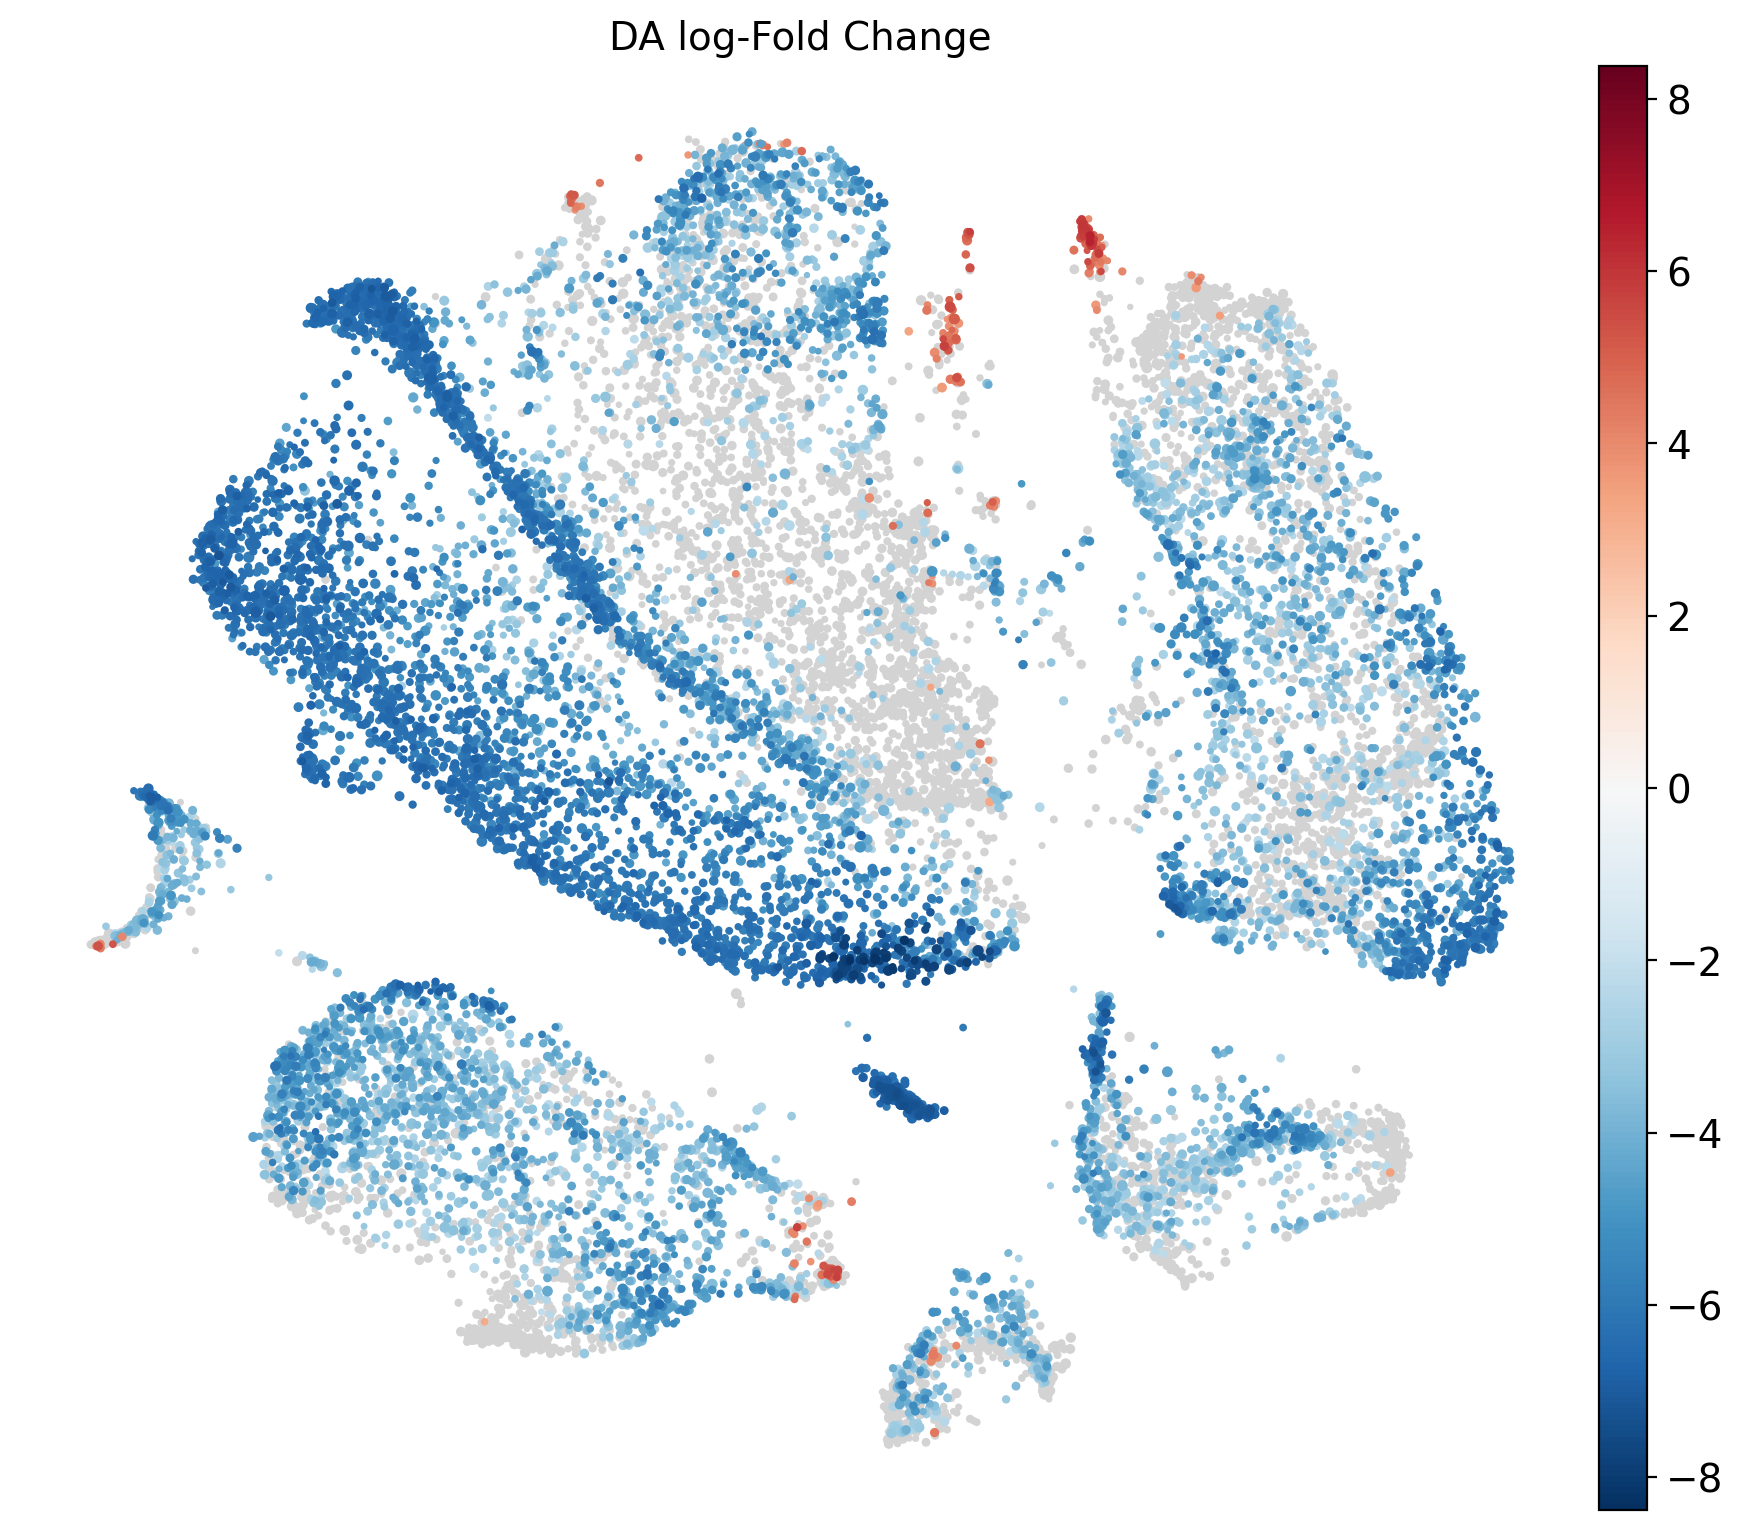

In [52]:
plt.rcParams["figure.figsize"] = [11,9.5]
milopl.plot_nhood_graph(adata, 
                        alpha=0.01, ## SpatialFDR level (1%) 
                        min_size=0.2, ## Size of smallest dot
                        plot_edges = False)

In [53]:
milopy.utils.annotate_nhoods(adata, anno_col='cell_type')

Text(0.5, 0, 'celltype fraction')

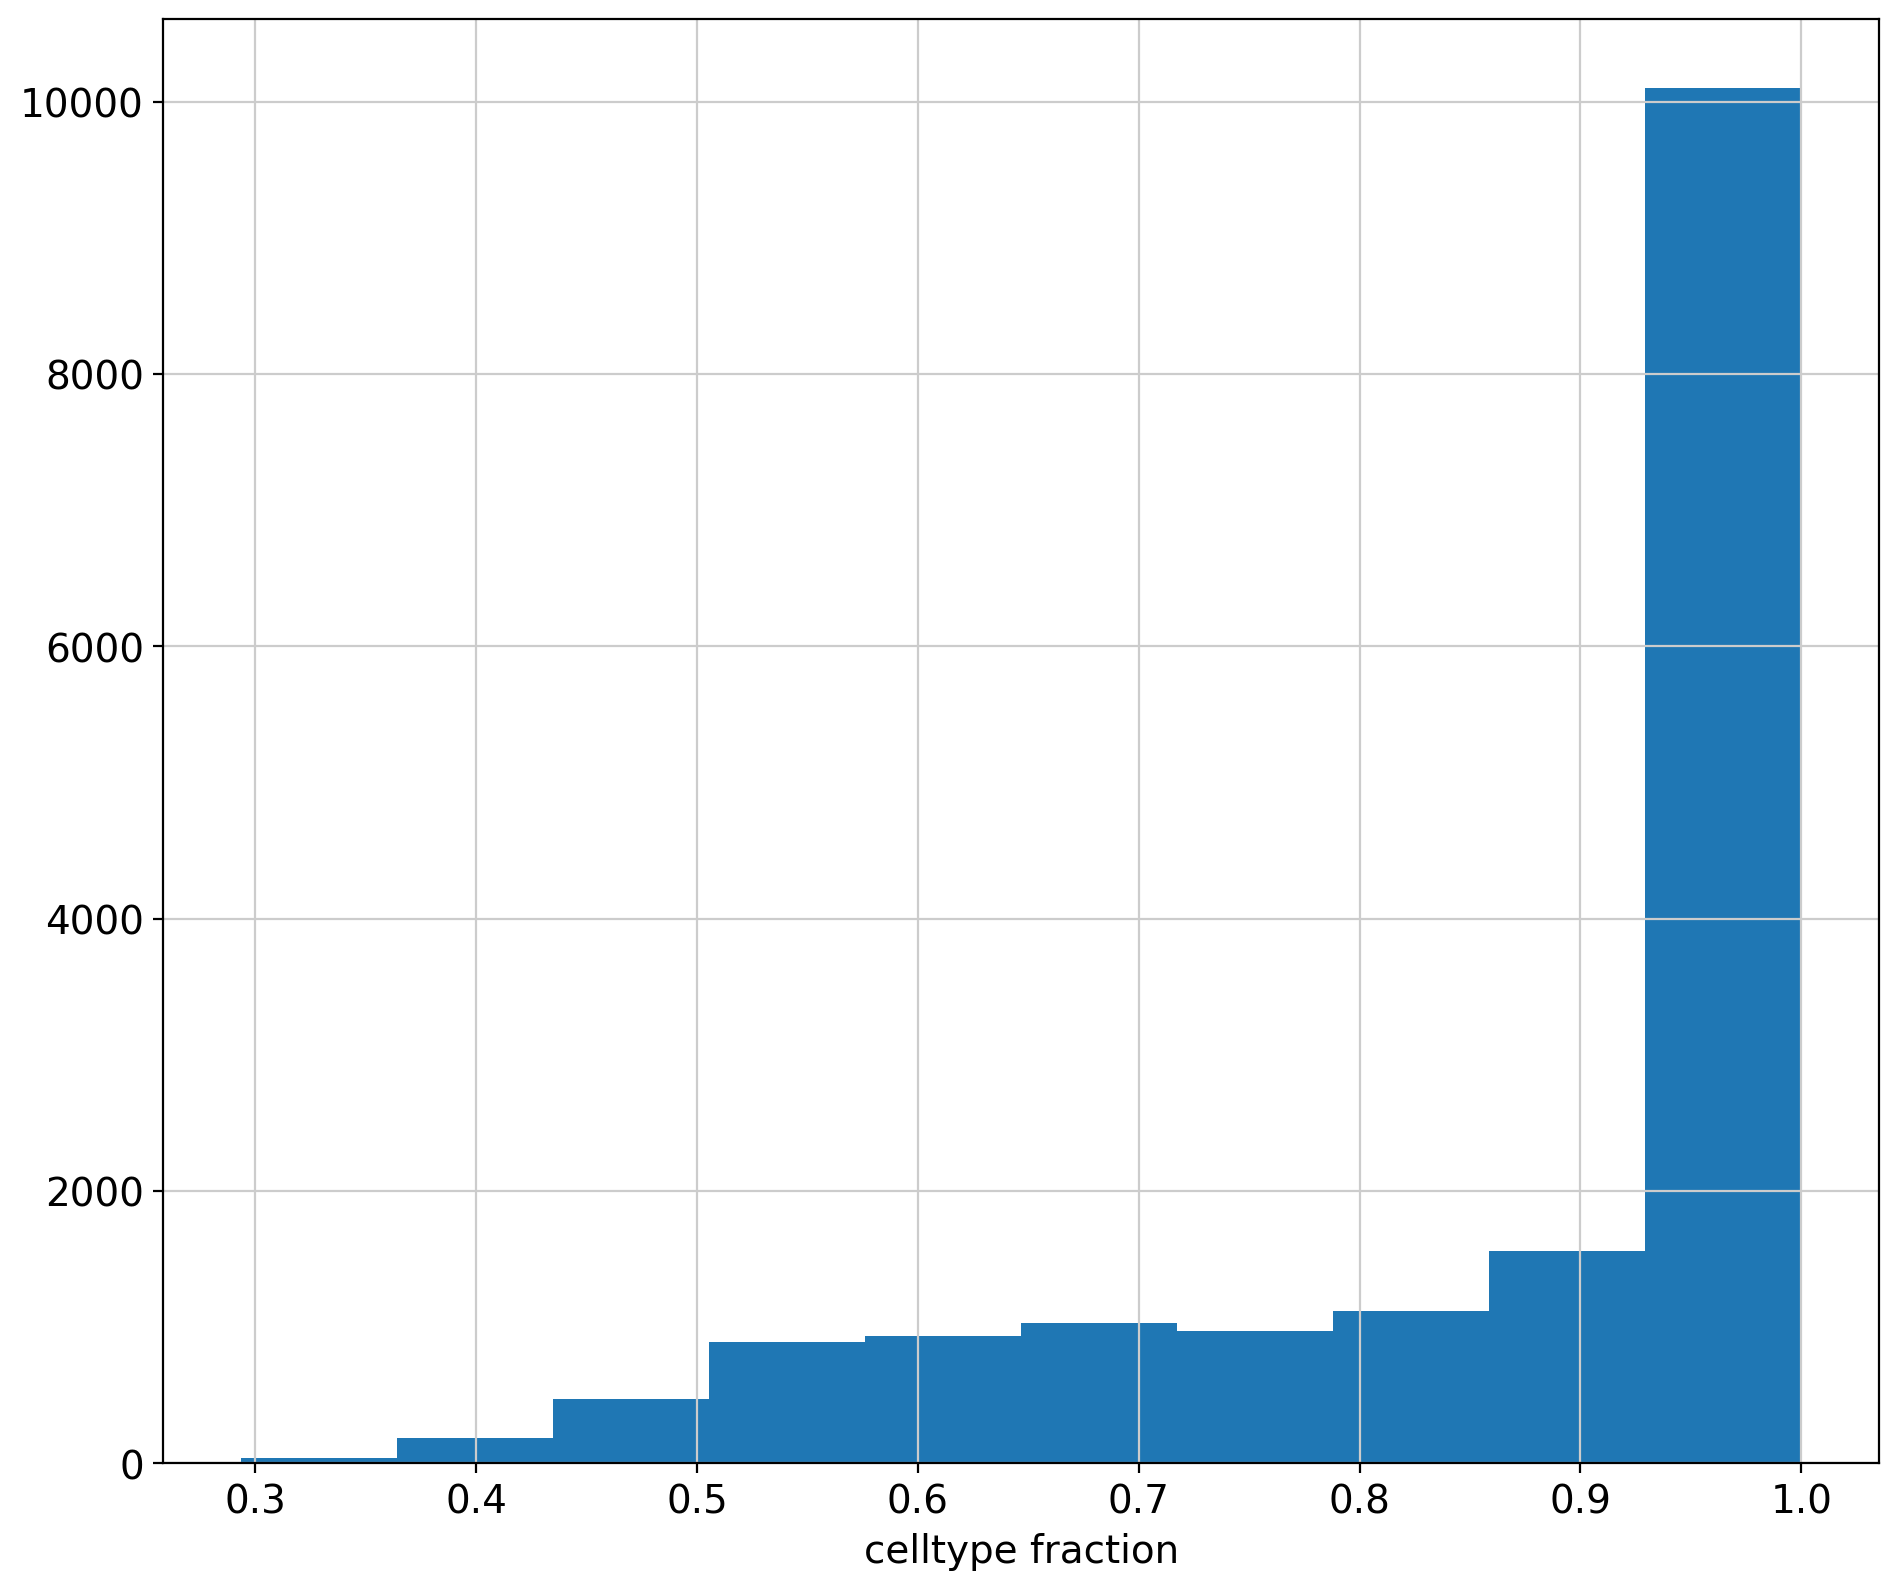

In [54]:
plt.hist(adata.uns['nhood_adata'].obs["nhood_annotation_frac"]);
plt.xlabel("celltype fraction")

In [55]:
adata.uns['nhood_adata'].obs.loc[adata.uns['nhood_adata'].obs["nhood_annotation_frac"] < 0.8, "nhood_annotation"] = "Mixed"

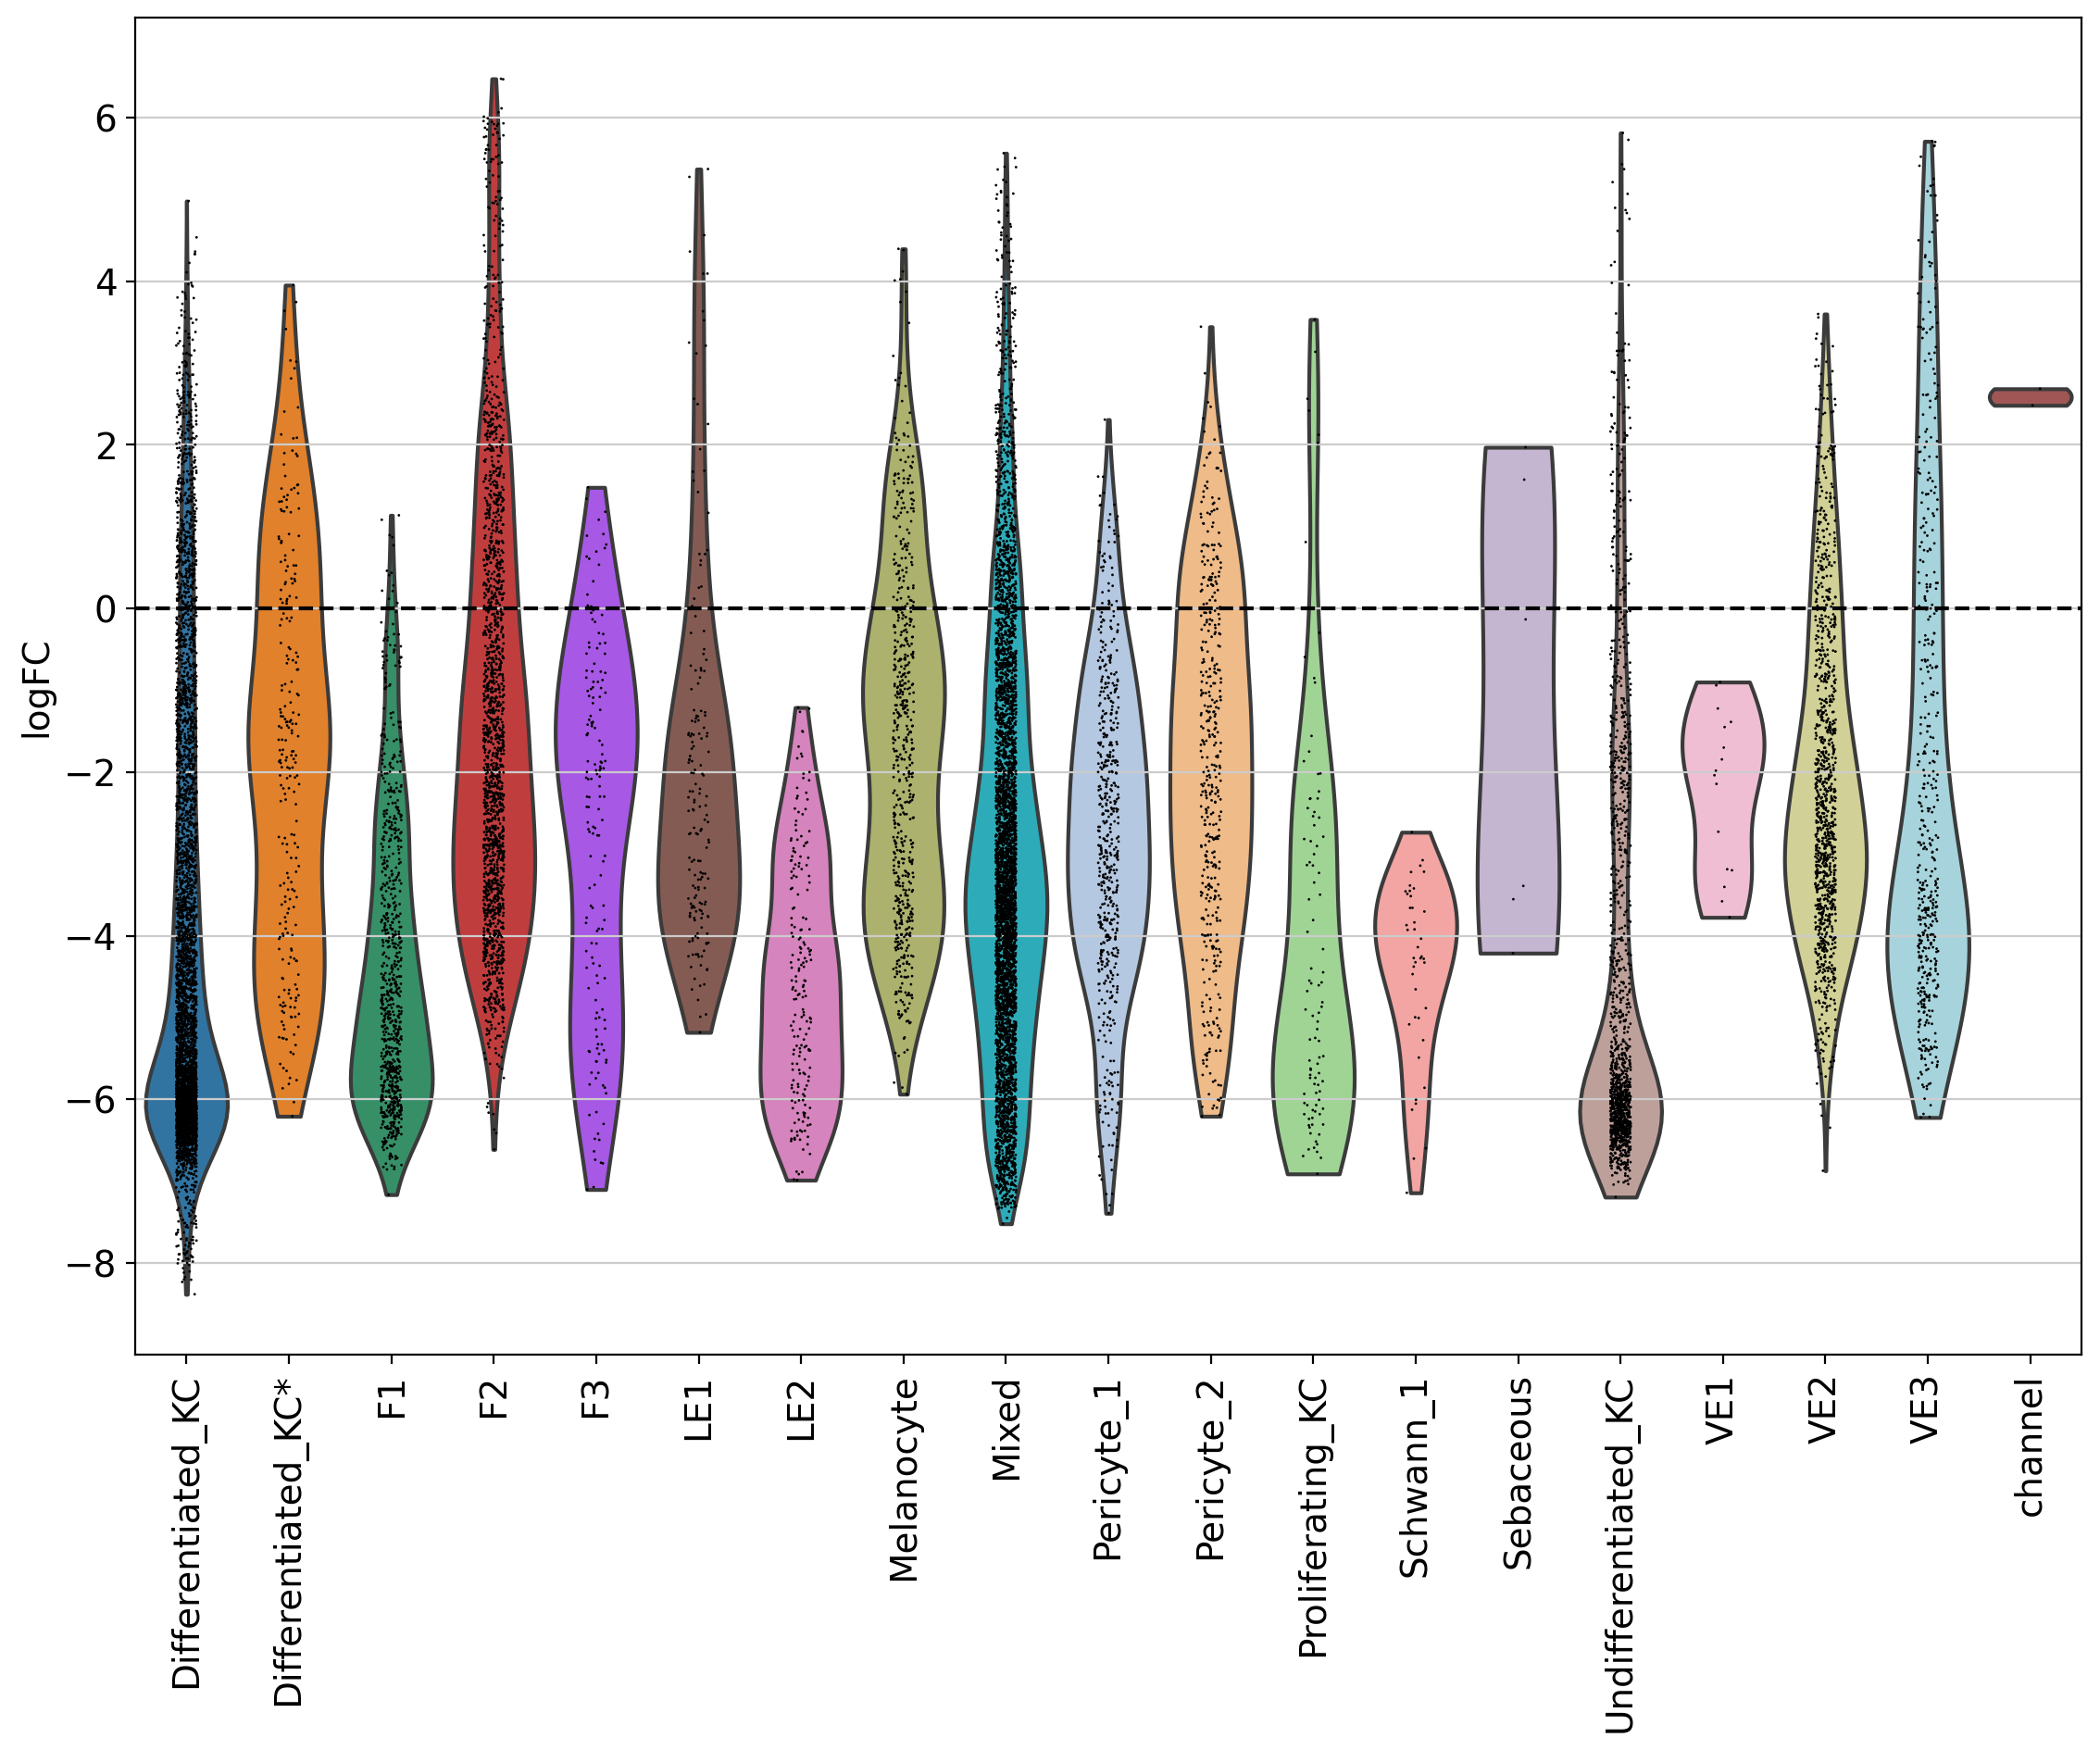

In [56]:
sc.pl.violin(adata.uns['nhood_adata'], "logFC", groupby="nhood_annotation", rotation=90, show=False);
plt.axhline(y=0, color='black', linestyle='--');
plt.show()

In [57]:
adata.uns["nhood_adata"].obs.to_csv('nhood_milo_stroma.csv')

In [58]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()

In [59]:
%load_ext rpy2.ipython

In [60]:
%%R
library(miloR)
library(igraph)
library(SingleCellExperiment)
library(scater)
library(scran)
library(dplyr)
library(patchwork)

In [61]:
%%R 
DA_results <- read.csv('nhood_milo_stroma.csv')
DA_results$Nhood <- DA_results$Nhood+1
DA_results %>% head

  X                           index_cell kth_distance      logFC   logCPM
1 0 AAACCTGCACGAGAGT-0_CTCL1_CTCL1_CTCL1    1.4881949 -0.3854633 8.400956
2 1 AAACGGGGTCATCCCT-0_CTCL1_CTCL1_CTCL1    1.3089602  0.1906575 8.485743
3 2 AAAGATGCATTGCGGC-0_CTCL1_CTCL1_CTCL1    1.0675657  0.6636647 8.537818
4 3 AAAGCAACATGCATGT-0_CTCL1_CTCL1_CTCL1    0.9481121 -2.0557206 8.281745
5 4 AAAGTAGAGGCCCGTT-0_CTCL1_CTCL1_CTCL1    1.0632510  0.3365970 8.577043
6 5 AACCATGGTACCGGCT-0_CTCL1_CTCL1_CTCL1    1.0000533  0.5072870 8.751248
           F     PValue        FDR SpatialFDR Nhood_size  nhood_annotation
1 0.16685835 0.68420893 0.72441959 0.72168053        133 Differentiated_KC
2 0.03657112 0.84891352 0.87094755 0.86940599        137             Mixed
3 0.40810133 0.52509127 0.57508256 0.57143595        143        Melanocyte
4 6.89466676 0.01068092 0.01586876 0.01536397        140        Melanocyte
5 0.09997158 0.75283700 0.78635698 0.78406889        158        Melanocyte
6 0.17899157 0.67358288 0.714655

In [62]:
%%R 
DA_results_filter <- DA_results[DA_results$SpatialFDR < 0.01,]
DA_results_filter %>% head

    X                           index_cell kth_distance     logFC   logCPM
15 14 AAGGCAGCATACGCTA-0_CTCL1_CTCL1_CTCL1    0.9911226  4.118145 8.692449
16 15 AAGGTTCCATGCTAGT-0_CTCL1_CTCL1_CTCL1    0.9798458  4.008086 8.734399
17 16 AAGGTTCTCGGTCTAA-0_CTCL1_CTCL1_CTCL1    1.0945321 -2.961828 8.351023
23 22 ACAGCCGGTTGTACAC-0_CTCL1_CTCL1_CTCL1    1.1733566  3.910934 8.622954
37 36 ACGTCAAAGCTTCGCG-0_CTCL1_CTCL1_CTCL1    1.1704707 -2.639062 8.752888
38 37 ACGTCAACAGGTTTCA-0_CTCL1_CTCL1_CTCL1    1.1803221 -3.442421 8.711362
           F       PValue          FDR   SpatialFDR Nhood_size
15  9.169090 0.0034814889 0.0054920288 0.0052822931        160
16  8.374713 0.0051157390 0.0079093401 0.0076245348        162
17 14.898185 0.0002560151 0.0004637847 0.0004395621        139
23  9.124906 0.0035562058 0.0056017279 0.0053888409        144
37  8.192559 0.0055930718 0.0086058347 0.0083003004        186
38 14.615922 0.0002894476 0.0005201584 0.0004934758        173
      nhood_annotation nhood_annot

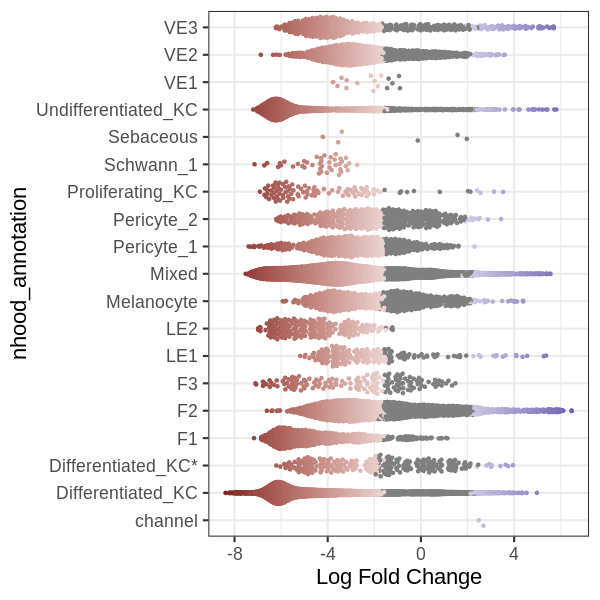

In [63]:
%%R -w 600 -h 600
plotDAbeeswarm(DA_results, group.by = "nhood_annotation")

In [66]:
%%R -w 800 -h 900 
library(ggplot2)

DA_results_filter <- DA_results[DA_results$nhood_annotation != 'Mixed' & 
                                DA_results$nhood_annotation != 'Sebaceous' &
                                DA_results$nhood_annotation != 'channel', ]

plotDAbeeswarm(DA_results_filter, group.by = "nhood_annotation") + 
    theme(legend.position = "none") +
    #theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())+
    geom_hline(yintercept=0, linetype=2, color="black")+
    scale_colour_gradient2(low = scales::muted("blue"), mid = "white",
                           high = scales::muted("red"))

ggsave("./figures/milo_stroma.pdf")
### "cell_states" represents pre-defined/pre-annotated cell clusters

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Saving 11.1 x 12.5 in image
